In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seqm
from xbbg import blp
import datetime as dt
plt.style.use('dark_background')

In [5]:
tickers = ['ES1 A:00_0_R Index','TY1 A:00_0_R Comdty', 'VG1 A:00_0_R Index', 'RX1 A:00_0_R Comdty']
# load data
data_load=blp.bdh(
                tickers=tickers,
                flds=['PX_LAST'],
                start_date='1980-01-01',
                end_date=dt.datetime.now().strftime('%Y-%m-%d'),
                timeout=100000
                )
# data_load.columns = data_load.columns.droplevel(1)
data_load.index=pd.to_datetime(data_load.index)
data_load

,ES1 A:00_0_R Index,TY1 A:00_0_R Comdty,VG1 A:00_0_R Index,RX1 A:00_0_R Comdty
,PX_LAST,PX_LAST,PX_LAST,PX_LAST
1982-05-04,NaN,25.203125,NaN,NaN
1982-05-05,NaN,25.250000,NaN,NaN
1982-05-06,NaN,25.609375,NaN,NaN
1982-05-07,NaN,25.703125,NaN,NaN
1982-05-10,NaN,25.656250,NaN,NaN
...,...,...,...,...
2024-07-24,5472.00,110.671875,4887.0,132.34
2024-07-25,5441.25,110.796875,4838.0,132.64
2024-07-26,5499.00,111.203125,4890.0,132.72


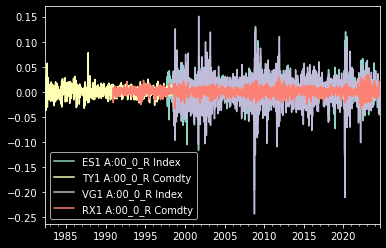

In [31]:
# create returns
data = data_load.copy(deep = True)
# put is in weekly format
data = data.resample('W-FRI').last()
data = data.pct_change()
data.columns = data.columns.droplevel(1)
data.plot()
plt.show()


In [32]:
# create dataset (some can start earlier than others)
tmp_dict = {}
for c in data.columns:
    tmp = data[[c]].copy(deep = True)
    tmp = tmp.dropna()
    tmp.columns = ['y1']
    tmp_dict.update({c:tmp})
dataset = seqm.Dataset(tmp_dict)


In [57]:
# create model pipe
model_pipes = seqm.ModelPipes()
for key in dataset.keys():
    # instantiate a model
    model = seqm.MovingAverage(
                        windows = [10], 
                        quantile = 0.9, 
                        vary_weights = True
                        )
    #model = seqm.NIGTrack(
    #                    phi_m = 0.95,
    #                    phi_v = 0.95,
    #                    vi = True
    #                    )
    # create a pipe for data
    # apply a rolling estimation to make a inverse vol allocation
    model_pipe_ = seqm.ModelPipe(
                                x_transform = seqm.RollPWScaleTransform(window=10, delay = 1),
                                y_transform = seqm.RollPWScaleTransform(window=10, delay = 1),
                                model = model)
    # store pipe in pipes
    model_pipes[key] = model_pipe_

In [58]:
paths=dataset.cvbt(
                model_pipes = model_pipes, 
                k_folds = 4, 
                seq_path = False, 
                start_fold = 0, 
                n_paths = 5, 
                burn_fraction = 0.1, 
                min_burn_points = 3 
                )

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


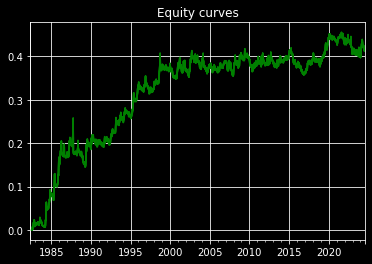

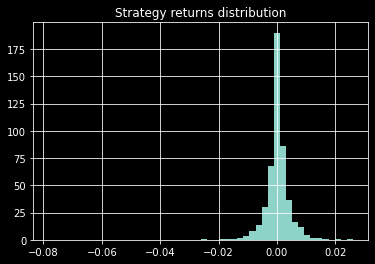

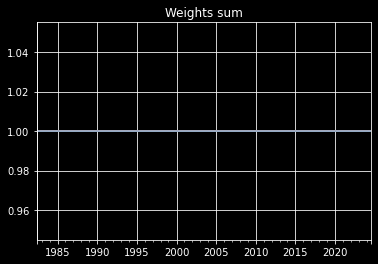

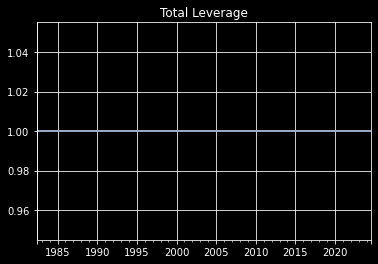

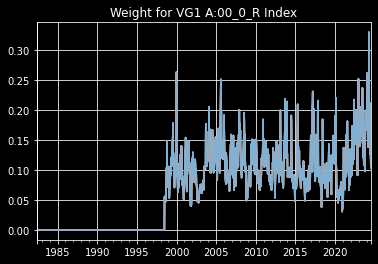

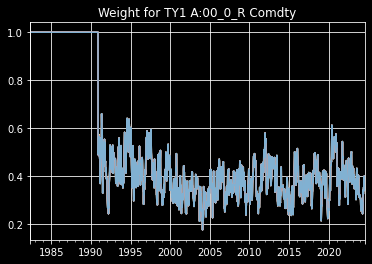

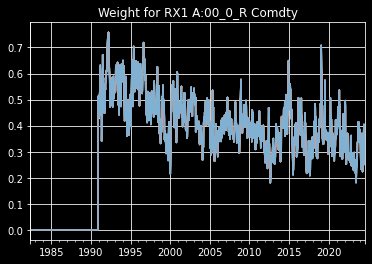

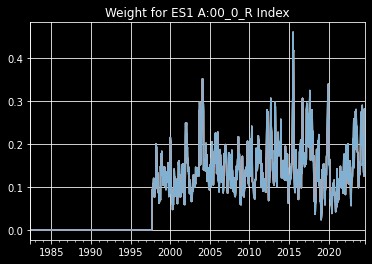

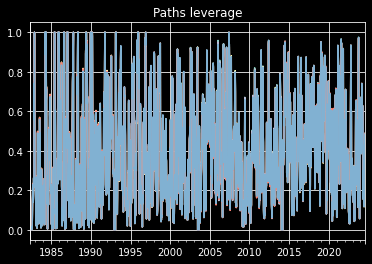

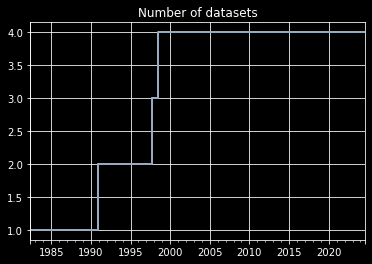


** REJECT STRATEGY **


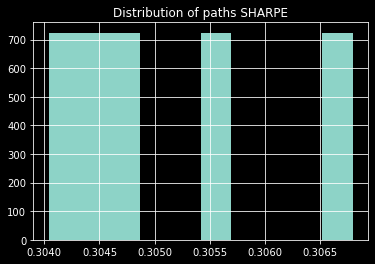

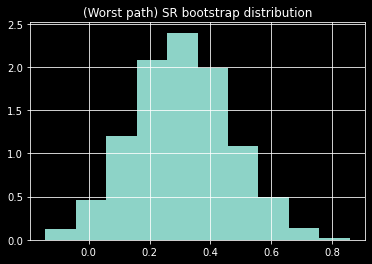


** PERFORMANCE SUMMARY **

Return:  0.009762568011993794
Standard deviation:  0.03199894338957293
Sharpe:  0.30509032417535986



In [59]:
# make a post process of the portfolio of strategies
seqm.portfolio_post_process(
        paths = paths, 
        pct_fee = 0., # put some fees
        seq_fees = True,
        sr_mult = np.sqrt(52),
        n_boot = 1000,
        view_weights = True, # view individual assets weights
        # use the portfolio weights from the rolling estimation, otherwise is equal weight        
        use_pw = True, 
        multiplier = 1
        )


In [60]:
0.39

0.39